In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy import units as u
from blend_calc import *
from scipy.interpolate import interp1d
from neff_extrapolation import *
from scipy.optimize import curve_fit

mpl.rc('font', family='serif', serif = "cmr10", size=18)
mpl.rcParams['mathtext.fontset']='cm'
mpl.rcParams["errorbar.capsize"] = 5
mpl.rcParams['axes.unicode_minus'] = False
DIRECTORY = '/mnt/44868D0F868D02A2/Users/veome/Google Drive/Academics/Senior Thesis/Code/Catalog/'

In [2]:
# cosmos = np.genfromtxt(DIRECTORY+'acs_cosmos1361.gcat_ascii', usecols=range(0,10), invalid_raise=False)
cosmos = np.genfromtxt('superbit_cosmos1361_shape_mag26.gcat_ascii', usecols=range(0,13), invalid_raise=False)
# cosmos = np.genfromtxt('superbit19_cosmos1361_lum_mag26.gcat_ascii', usecols=range(0,13), invalid_raise=False)

print("Original Catalog Size: %i"%cosmos.shape[0])

#  Redshift > 0 Cut
cosmos = cosmos[cosmos[:,2]>0] #cut is already in generate_catalog.py
print("New Catalog Size: %i"%cosmos.shape[0])

Original Catalog Size: 389181
New Catalog Size: 389181


In [3]:
# Calculate SuperBIT PSF
lam = 680 * u.nm
theta = 1.22 * lam  * u.rad / (0.5*u.m) # in radians
theta = theta.to(u.arcsec) # in arcsec to combine with jitter
jitter = 0.118 * u.arcsec

psf = np.sqrt(jitter**2 + theta**2)
SUPERBIT_PSF = psf.to(u.arcsec).value # in arcsec
print("SuperBIT PSF: %.3f\"" %SUPERBIT_PSF)

# Calculate SuperBIT PSF for f814W Mags
lam = 814 * u.nm
theta = 1.22 * lam  * u.rad / (0.5*u.m) # in radians
theta = theta.to(u.arcsec) # in arcsec to combine with jitter
jitter = 0.118 * u.arcsec

psf = np.sqrt(jitter**2 + theta**2)
SUPERBIT_F814W_PSF = psf.to(u.arcsec).value # in arcsec
print("SuperBIT F814W PSF: %.3f\"" %SUPERBIT_F814W_PSF)

PIX_TO_ARCSEC = 0.05 # arcsec per HST ACS pixel (Koekemoer et. al. 2007)
ARCSEC_TO_PIX = 1/PIX_TO_ARCSEC # HST ACS pixel per arcsec

SuperBIT PSF: 0.362"
SuperBIT F814W PSF: 0.426"


In [4]:
MAG_MIN = 21.0
MAG_MAX = 26.0

# Extrapolation Theory

Let's say we can only detect background sources which are larger than 1.2 $\cdot$ PSF.

From Richard, etc we know that N ~doubles with mag:
$$ N \propto a^{mag}$$
where $a \sim 2$ from empirical results.

But also, when we convert to another band, we will observe
$$N_{\text{eff}} = f(mag) N$$
where $f(mag)$ is some fraction which we have to determine, and is defined as $$f(mag) = \frac{\text{# of sources at } mag > 1.2 \text{PSF}}{\text{total # of sources at } mag}.$$

Thus, we get the final relation
$$N_{\text{eff}}(mag) = N_0 \cdot 2^{mag} \int_0^{mag} f(mag') \text{ d } mag'$$


We first want to know $f(mag)$, for the SuperBIT Shape band, which we can plot from the catalog data.

The following plot gives the fraction of sources larger than 1.2 times the SuperBIT PSF vs Mag.

# F vs Mag Cut

In [5]:
mags = np.arange(MAG_MIN, MAG_MAX, 0.2)

magcut = np.empty(mags.shape)
magcut_err =  np.empty(mags.shape)

for i in range(mags.shape[0]):
    cat = cosmos
    # perform magcut
    cat = cat[cat[:,5]<=mags[i]]
    n_total = cat.shape[0]
    
    # perform size cut
    cat = cat[cat[:,9] * PIX_TO_ARCSEC > 1.2*SUPERBIT_PSF]
    n_eff = cat.shape[0]
    
    magcut[i] = n_eff / n_total
    magcut_err[i] = np.sqrt((1/ n_total) + (1/n_eff))


# magcut_err = magcut_err * np.std(magcut)

# Interpolated Function
f_magcut = interp1d(mags, magcut)

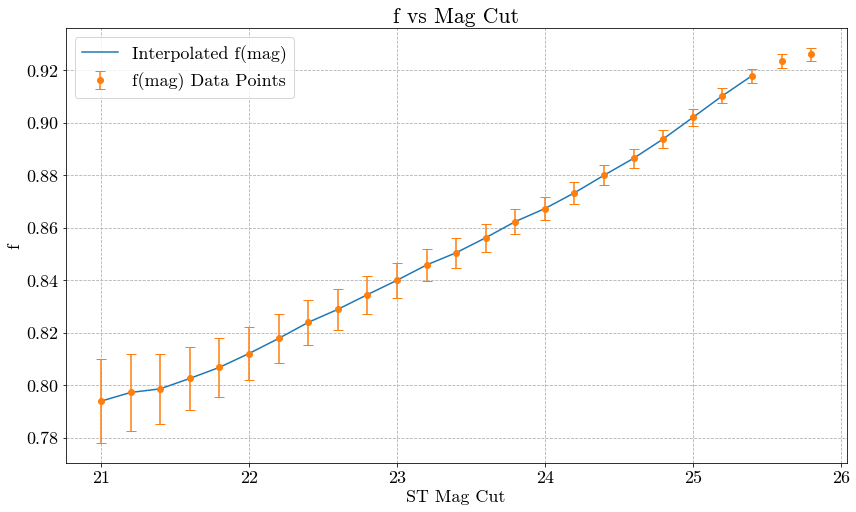

In [6]:
plt.figure(figsize=(14,8))

# Plot the interpolated function
x = np.arange(MAG_MIN, MAG_MAX-0.5, 0.2)
plt.plot(x, f_magcut(x), label='Interpolated f(mag)')

# Plot the data points
plt.errorbar(mags, magcut, yerr=magcut_err,fmt='o', label='f(mag) Data Points')

plt.title("f vs Mag Cut")
plt.xlabel("ST Mag Cut")
plt.ylabel('f')
plt.legend()
plt.grid(linestyle='--')

# F vs Mag

In [7]:
mags = np.arange(MAG_MIN, MAG_MAX, 0.2)

f_mag_data = np.empty(mags.shape)
f_mag_data_err =  np.empty(mags.shape)

for i in range(mags.shape[0]):
    cat = cosmos
    # perform magcut
    cat = cat[cat[:,5]< mags[i] + 0.1]
    cat = cat[cat[:,5]> mags[i] - 0.1]
    n_total = cat.shape[0]
    
    # perform size cut
    cat = cat[cat[:,9] * PIX_TO_ARCSEC > 1.2*SUPERBIT_PSF]
    n_eff = cat.shape[0]
    
    f_mag_data[i] = n_eff / n_total
    f_mag_data_err[i] = np.sqrt((1/ n_total) + (1/n_eff))

# Interpolation function
f_mag = interp1d(mags, f_mag_data)

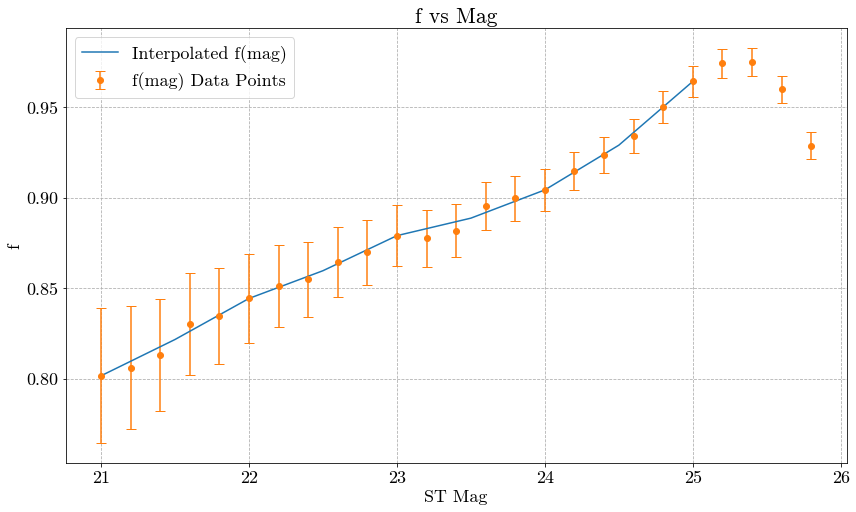

In [8]:
plt.figure(figsize=(14,8))


# Plot the interpolated function
x = np.arange(MAG_MIN, MAG_MAX-0.5, 0.5)
plt.plot(x, f_mag(x), label='Interpolated f(mag)')

# Plot the data points
plt.errorbar(mags, f_mag_data, yerr=f_mag_data_err,fmt='o', label='f(mag) Data Points')

plt.title("f vs Mag")
plt.xlabel("ST Mag")
plt.ylabel('f')
plt.legend()
plt.grid(linestyle='--')

# Doubling Relation

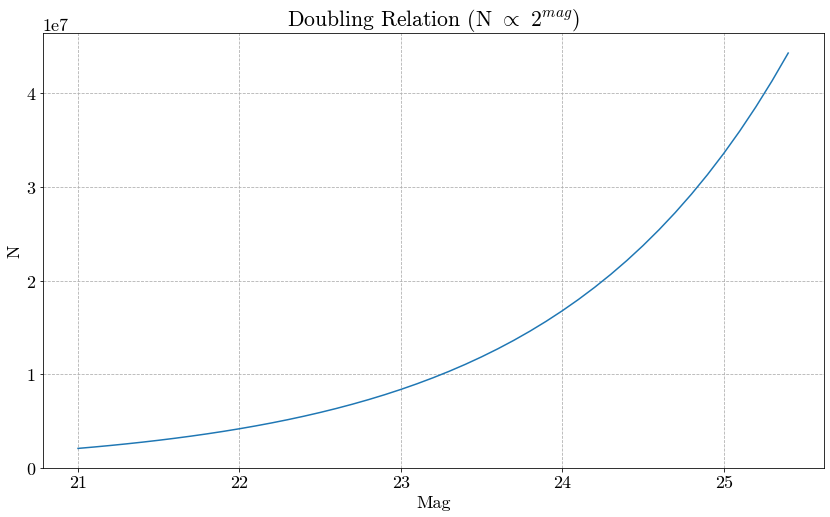

In [9]:
x = np.arange(MAG_MIN, MAG_MAX-0.5, 0.1)
a = 2**x


plt.figure(figsize=(14,8))

plt.plot(x, a)

plt.title("Doubling Relation (N $\propto$ 2$^{mag}$)")
plt.xlabel("Mag")
plt.ylabel('N')

plt.grid(linestyle='--')



# Combined Function Interpolation

In [10]:
x = np.arange(MAG_MIN, MAG_MAX-0.3, 0.1)
y = 2**x * f_magcut(x)

# Combined function
f = interp1d(x, y)

Text(0.5, 1.0, 'Combined Function')

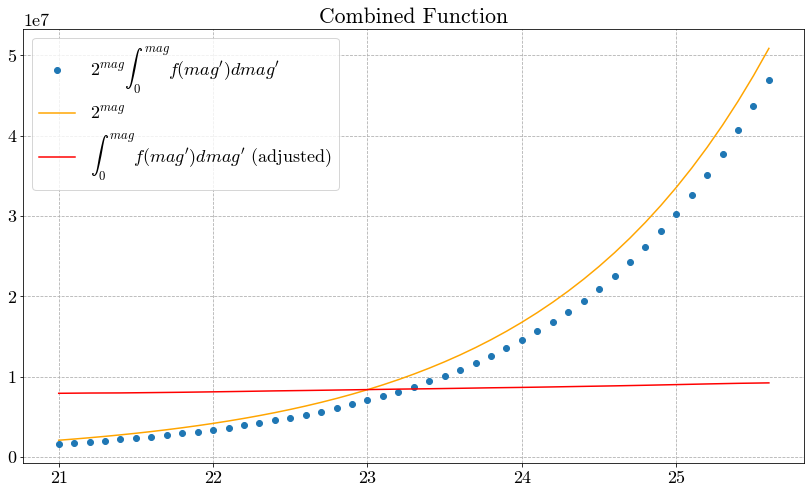

In [11]:
plt.figure(figsize=(14,8))

plt.plot(x, f(x), 'o', label='$2^{mag} \int_0^{mag} f(mag\') d mag\'$')

# Only the Doubling Term
plt.plot(x, 2**x, label='$2^{mag}$', color='orange')

# Only the Fraction Term
plt.plot(x, 10**7 * f_magcut(x), label='$ \int_0^{mag} f(mag\') d mag\'$ (adjusted)', color='red')

plt.legend()
plt.grid(linestyle='--')
plt.title('Combined Function')

# Module Test

In [12]:
f_test = get_n_mag(MAG_MIN, MAG_MAX, 0.2, SUPERBIT_PSF, cosmos)

Text(0.5, 1.0, 'Module Test')

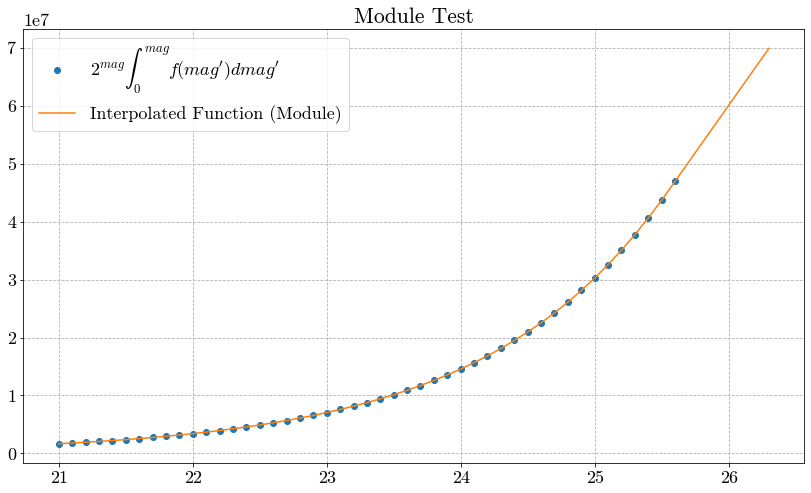

In [13]:
plt.figure(figsize=(14,8))

x = np.arange(MAG_MIN, MAG_MAX-0.3, 0.1)
x1 = np.arange(MAG_MIN, MAG_MAX+0.3, 0.1)
y = 2**x * f_magcut(x)

# Combined function
plt.plot(x, y, 'o', label='$2^{mag} \int_0^{mag} f(mag\') d mag\'$')

# From Module
plt.plot(x1, f_test(x1), label='Interpolated Function (Module)')

plt.legend()
plt.grid(linestyle='--')
plt.title('Module Test')

# Best Fit using Interpolated Function

In [18]:
f_test = get_n_mag(MAG_MIN, MAG_MAX, 0.2, SUPERBIT_PSF, cosmos)

x = np.linspace(MAG_MIN, MAG_MAX, 18)
data = [1.0, 2.0, 2.0, 3.0, 4.0, 5.0, 7.0, 9.0, 11.0, 13.5, 18.0, 22.0, 27.0, 33.0, 41.0, 49.0, 58.0, 67.5] #from hst median data

best_vals, covar = get_n_fit(x, data, f_test)
print(best_vals)

[3.21189342e-06 9.61196073e-01]


Amplitude = 3.2118934182098183e-06, Exponent Base = 0.961196072780947


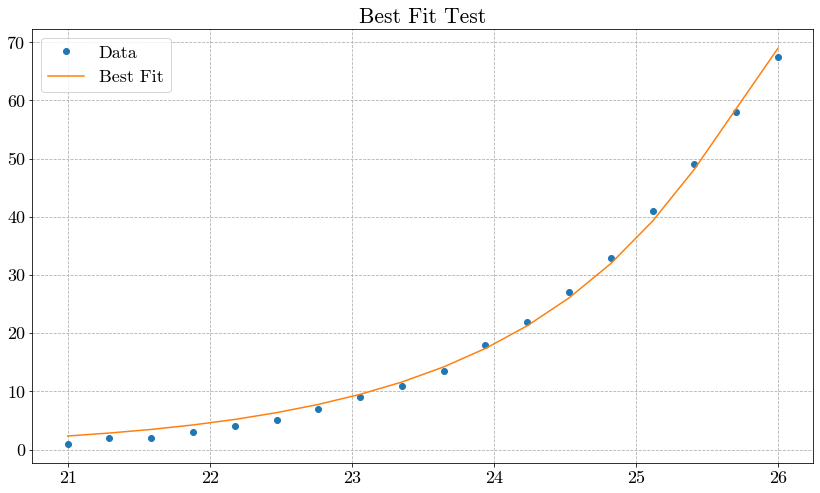

In [19]:
plt.figure(figsize=(14,8))

# Data
plt.plot(x, data, 'o', label='Data')

# Best Fit
plt.plot(x, n_extrapolation(x, *best_vals, f_test), label='Best Fit')

plt.legend()
plt.grid(linestyle='--')
plt.title('Best Fit Test')

print("Amplitude = {}, Exponent Base = {}".format(*best_vals))

# Size vs Mag (Complete Catalog)

In [16]:
magcut = 26.0
cat = cosmos[cosmos[:,5]<=magcut]
n_total = cat.shape[0]
n_eff = cat[cat[:,9]>1.2*SUPERBIT_PSF*ARCSEC_TO_PIX].shape[0]
print("Total sources below stmag {}: {}".format(magcut, n_total))
print("Sources below stmag {}, larger than 1.2 x PSF: {}".format(magcut, n_eff))
print("f(magcut): {}".format(n_eff/n_total))

Total sources below stmag 26.0: 389181
Sources below stmag 26.0, larger than 1.2 x PSF: 359743
f(magcut): 0.9243591028338999


(15.0, 26.0)

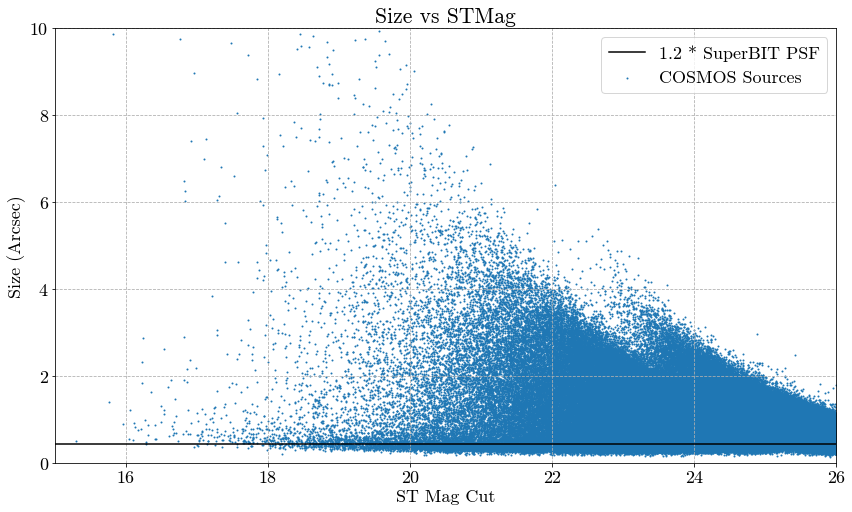

In [17]:
plt.figure(figsize=(14,8))

plt.scatter(cosmos[:,5], cosmos[:,9]*PIX_TO_ARCSEC, s=1, label='COSMOS Sources')
plt.plot([0, 26], [1.2*SUPERBIT_PSF, 1.2*SUPERBIT_PSF], 'k-', label='1.2 * SuperBIT PSF')

plt.title("Size vs STMag")
plt.xlabel("ST Mag Cut")
plt.ylabel('Size (Arcsec)')
plt.legend()
plt.grid(linestyle='--')

plt.ylim(0, 10)
plt.xlim(15, 26)